In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_set = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 141kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


In [4]:
class CNN(nn.Module):
    def __init__(self, activation=nn.ReLU, use_bn=False, dropout=0.0):
        super(CNN, self).__init__()

        layers = [
            nn.Conv2d(1, 32, 3, padding=1),
            activation()
        ]
        if use_bn:
            layers.append(nn.BatchNorm2d(32))

        layers += [
            nn.Conv2d(32, 64, 3, padding=1),
            activation()
        ]
        if use_bn:
            layers.append(nn.BatchNorm2d(64))

        layers += [
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout)
        ]

        self.features = nn.Sequential(*layers)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            activation(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_layers, activation=nn.ReLU):
        super(MLP, self).__init__()

        layers = [nn.Flatten()]
        input_size = 784

        for h in hidden_layers:
            layers.append(nn.Linear(input_size, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(activation())
            input_size = h

        layers.append(nn.Linear(input_size, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()

    return total_loss / len(loader), 100 * correct / total


def test(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()

    return 100 * correct / total

In [7]:
activations = {
    "Sigmoid": nn.Sigmoid,
    "Tanh": nn.Tanh,
    "ReLU": nn.ReLU
}

results = []
histories = {}

for name, act in activations.items():
    model = CNN(activation=act).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    train_accs, test_accs = [], []

    for epoch in range(10):
        _, train_acc = train(model, train_loader, optimizer, criterion)
        test_acc = test(model, test_loader)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

    histories[name] = (train_accs, test_accs)
    results.append([name, "SGD", 10, test_acc])

In [8]:
optimizers = {
    "SGD": lambda p: optim.SGD(p, lr=0.01),
    "SGD+Momentum": lambda p: optim.SGD(p, lr=0.01, momentum=0.9),
    "Adam": lambda p: optim.Adam(p, lr=0.001)
}

for name, opt_fn in optimizers.items():
    model = CNN(activation=nn.ReLU).to(device)
    optimizer = opt_fn(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        train(model, train_loader, optimizer, criterion)

    acc = test(model, test_loader)
    results.append(["ReLU", name, 10, acc])

In [9]:
configs = [
    ("No BN, No Dropout", False, 0.0),
    ("No BN, Dropout=0.1", False, 0.1),
    ("BN, Dropout=0.25", True, 0.25)
]

for label, bn, dr in configs:
    model = CNN(use_bn=bn, dropout=dr).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        train(model, train_loader, optimizer, criterion)

    acc = test(model, test_loader)
    results.append([label, "Adam", 10, acc])

In [10]:
# MLP-1
mlp1 = MLP([512, 256, 128]).to(device)
opt1 = optim.SGD(mlp1.parameters(), lr=0.01)
for _ in range(20):
    train(mlp1, train_loader, opt1, nn.CrossEntropyLoss())
results.append(["MLP-1", "SGD", 20, test(mlp1, test_loader)])

# MLP-2
mlp2 = MLP([256]).to(device)
opt2 = optim.Adam(mlp2.parameters(), lr=0.001)
for _ in range(15):
    train(mlp2, train_loader, opt2, nn.CrossEntropyLoss())
results.append(["MLP-2", "Adam", 15, test(mlp2, test_loader)])

In [11]:
import pandas as pd

df = pd.DataFrame(
    results,
    columns=["Experiment / Activation", "Optimizer", "Epochs", "Final Accuracy"]
)

df

,Experiment / Activation,Optimizer,Epochs,Final Accuracy
0,Sigmoid,SGD,10,90.88
1,Tanh,SGD,10,97.74
2,ReLU,SGD,10,98.54
3,ReLU,SGD,10,98.64
4,ReLU,SGD+Momentum,10,99.11
5,ReLU,Adam,10,98.94
6,"No BN, No Dropout",Adam,10,98.79
7,"No BN, Dropout=0.1",Adam,10,99.11
8,"BN, Dropout=0.25",Adam,10,98.95
9,MLP-1,SGD,20,98.10


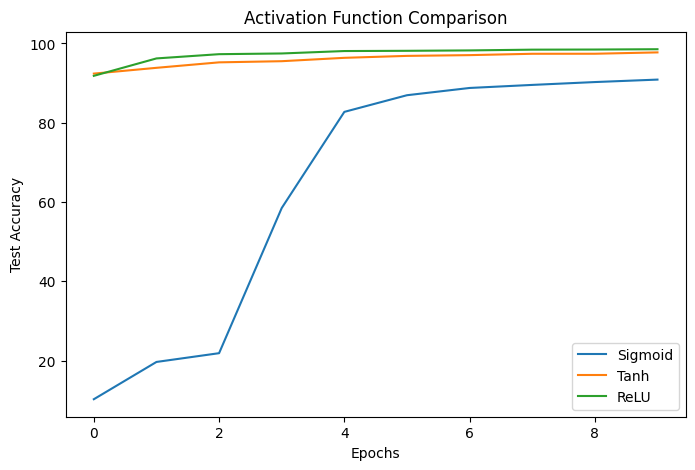

In [12]:
plt.figure(figsize=(8,5))
for k, (train_acc, test_acc) in histories.items():
    plt.plot(test_acc, label=k)

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("Activation Function Comparison")
plt.show()

* ReLU converges faster than Sigmoid and Tanh due to reduced vanishing gradients.

* Adam achieves higher accuracy faster than SGD and SGD with momentum.

* Batch Normalization + Dropout (0.25) provides best generalization.

* CNN outperforms MLP on MNIST due to spatial feature learning.